# Produce a surf report

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import datetime
import pandas as pd

from pysurfline import SpotForecast

List of known spot id

| Spot Id | Name |
|---|---|
| 5842041f4e65fad6a7708890 | Pipeline (USA)|
| 584204204e65fad6a7709b09 | Varazze (ITA)|

In [2]:
params={
    "spotId":"5842041f4e65fad6a7708890",
    "days":7,
    "intervalHours":3,
    }
spot=SpotForecast(params,verbose=True)


-----
ForecastGetter(Type:wave, Status:200)
-----
ForecastGetter(Type:wind, Status:200)
-----
ForecastGetter(Type:tides, Status:200)
-----
ForecastGetter(Type:weather, Status:200)


In [3]:
report=[]
for attr in ["wave","wind","weather"]: #exclude "tides" because of HIGH LOW exact times
    report.append(spot.get_dataframe(attr))
report=pd.concat(report,axis=1)
report.head()

,utcOffset,surf_min,surf_max,surf_optimalScore,swells,utcOffset,speed,direction,directionType,gust,optimalScore,utcOffset,temperature,condition
timestamp,,,,,,,,,,,,,,
2022-02-13 10:00:00,-10,1.555120,1.925840,0,"[{'height': 1.0067, 'period': 8, 'direction': ...",-10,26.17570,61.06052,Cross-shore,28.44523,0,-10,22.56595,NIGHT_BRIEF_SHOWERS_POSSIBLE
2022-02-13 13:00:00,-10,1.497900,1.813900,0,"[{'height': 1.09102, 'period': 8, 'direction':...",-10,25.13432,59.40920,Cross-shore,27.72073,0,-10,22.27188,NIGHT_CLEAR
2022-02-13 16:00:00,-10,1.440680,1.611960,0,"[{'height': 1.18276, 'period': 8, 'direction':...",-10,27.02486,63.20843,Cross-shore,29.17300,0,-10,22.22278,NIGHT_CLEAR
2022-02-13 19:00:00,-10,1.150483,1.455083,0,"[{'height': 1.34372, 'period': 6, 'direction':...",-10,27.23453,59.22836,Cross-shore,27.23453,0,-10,22.54321,CLEAR
2022-02-13 22:00:00,-10,1.224333,1.368333,0,"[{'height': 0.97719, 'period': 6, 'direction':...",-10,22.07972,54.38195,Cross-shore,22.07972,0,-10,22.72507,CLEAR


In [4]:
surf=report.copy()[["surf_min",	"surf_max","speed","directionType"]]
surf["surf_height"]=surf[["surf_min","surf_max"]].mean(axis=1)
surf.head()

,surf_min,surf_max,speed,directionType,surf_height
timestamp,,,,,
2022-02-13 10:00:00,1.555120,1.925840,26.17570,Cross-shore,1.740480
2022-02-13 13:00:00,1.497900,1.813900,25.13432,Cross-shore,1.655900
2022-02-13 16:00:00,1.440680,1.611960,27.02486,Cross-shore,1.526320
2022-02-13 19:00:00,1.150483,1.455083,27.23453,Cross-shore,1.302783
2022-02-13 22:00:00,1.224333,1.368333,22.07972,Cross-shore,1.296333


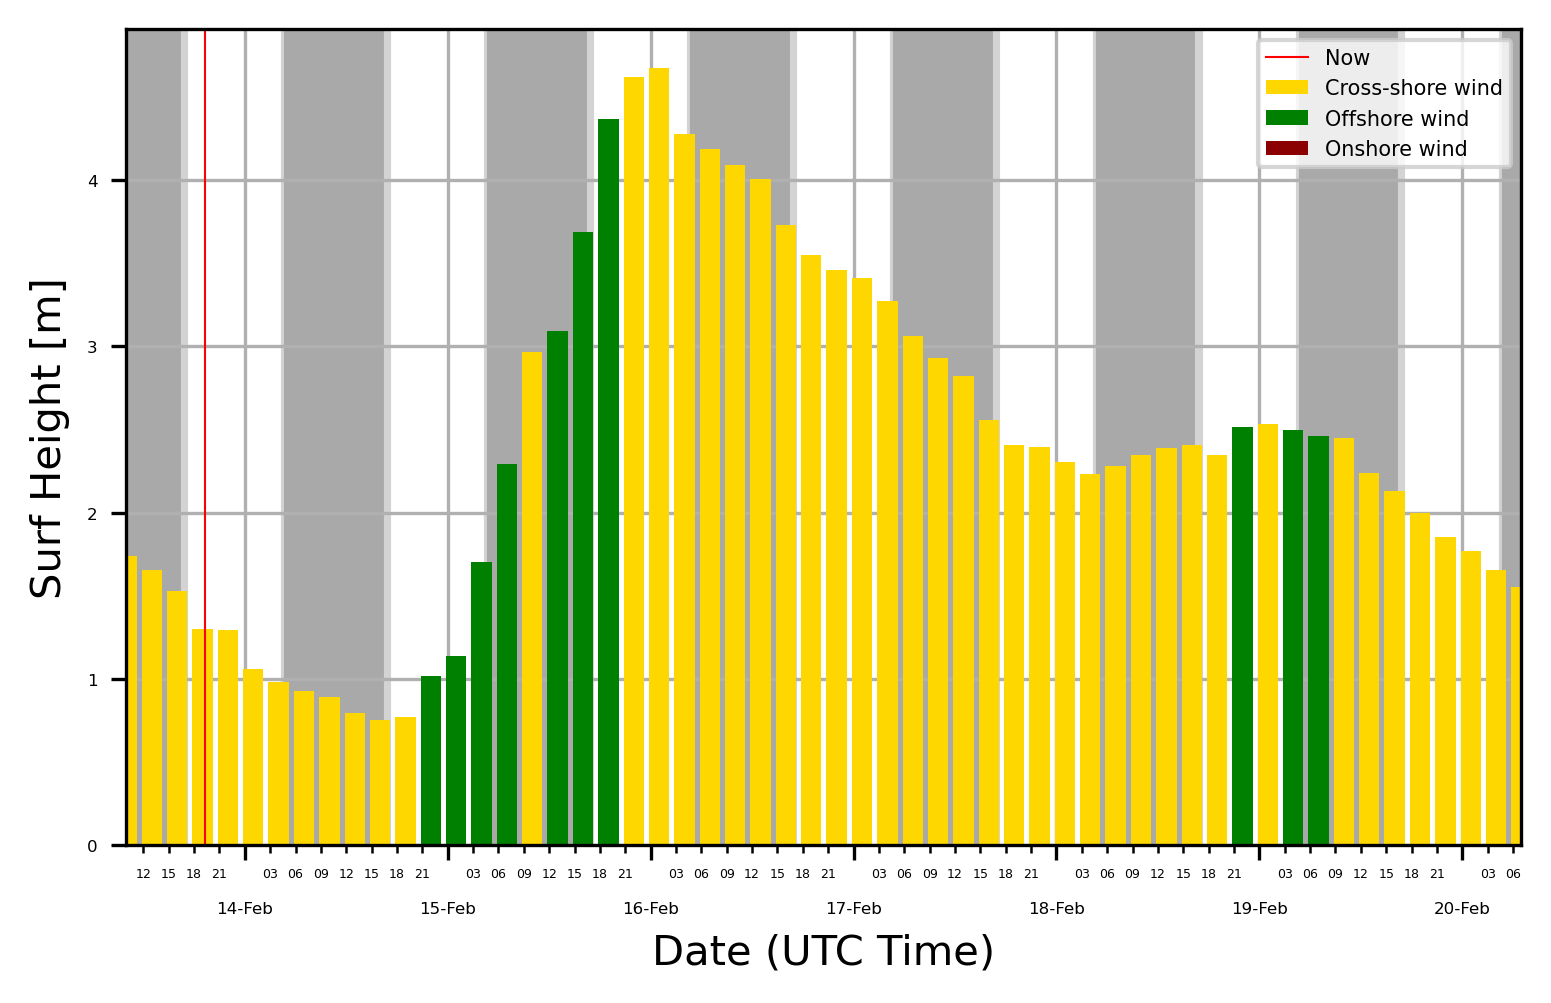

In [24]:
f,ax=plt.subplots(dpi=300)

colors={'Cross-shore':"gold", 'Offshore':"green", 'Onshore':"darkred"}
surf["hist_color"]=surf["directionType"].map(colors)
ax.grid(axis="y",zorder=0)
ax.bar(
    surf.index,
    surf["surf_height"],
    color=surf["hist_color"],
    zorder=2,width=0.1,
    )

if surf["surf_height"].max()<2:
    ax.set_ylim([0,2])

ax.grid(axis="y",zorder=0)
ax.grid(axis="x",which="major",zorder=10000)
ax.figure.autofmt_xdate()
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=(0,3,6,9,12,15,18,21)))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set(xlabel="Date (UTC Time)",ylabel="Surf Height [m]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_yticklabels(which='major'):
    label.set(rotation=0,size=4)
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0,horizontalalignment='center',size=4)
for label in ax.get_xticklabels(which='minor'):
    label.set( horizontalalignment='center',size=3)

ax.axvline(datetime.datetime.now(datetime.timezone.utc),color="r",label="Now",linewidth=0.5)

daylight=spot.get_dataframe("sunlightTimes")

ax.tick_params(axis='x', which='major', pad=10)
ax.set_xlim([surf.index[0],surf.index[-1]])
for i,x in daylight.iterrows():
    ax.axvspan(x["midnight"], x["dawn"],color="darkgrey")
    ax.axvspan(x["dawn"], x["sunrise"],color="lightgrey")
    ax.axvspan(x["sunset"], x["dusk"],color="lightgrey")
    ax.axvspan(x["dusk"], x["midnight"]+datetime.timedelta(days=1),color="darkgrey")

for key in colors:
    ax.bar([0],[0],color=colors[key],label=key+" wind")
ax.legend(fontsize=5)